# Using Clusters

You have created amazing clusters! Yay! At a minimum, you have a new piece of art. But what do you do now? How does this help you? Well (this answer will you surprise you), it depends.

Before we go there, lets rewind.

**The year:** 2010.

**The place:** Rackspace.

**The Characters** (and they were characters!): a Younger Maggie and Lanham Napier (former CEO of Rackscpace).

**The story:**

It started with a desk drive by...

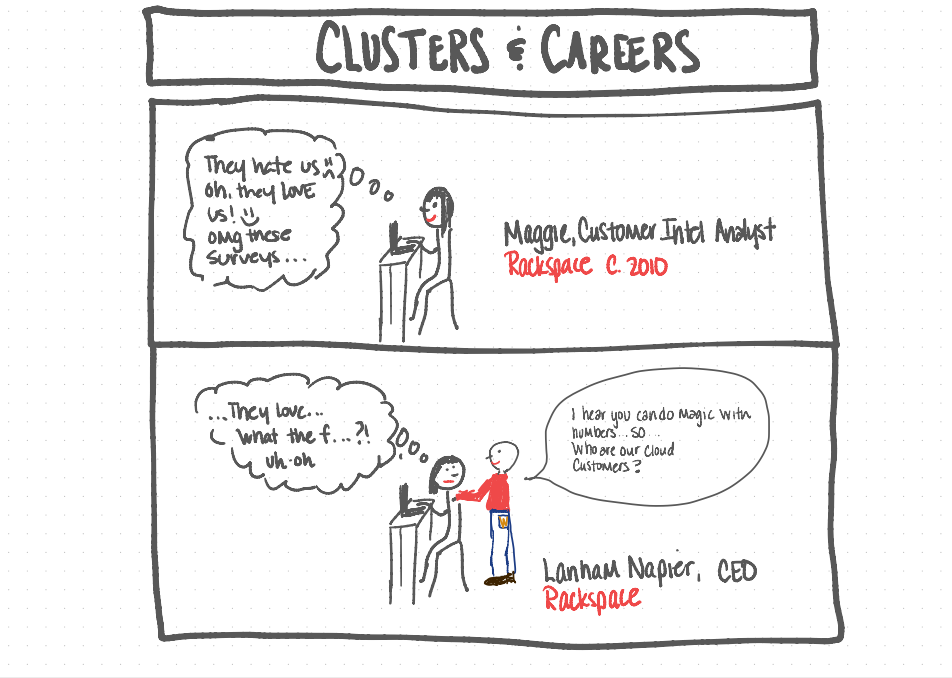

Which took me immediately to the white board to plan this out. This was my opportunity to show the need for data science at Rackspace! I wasn't going to fail for lack of planning.

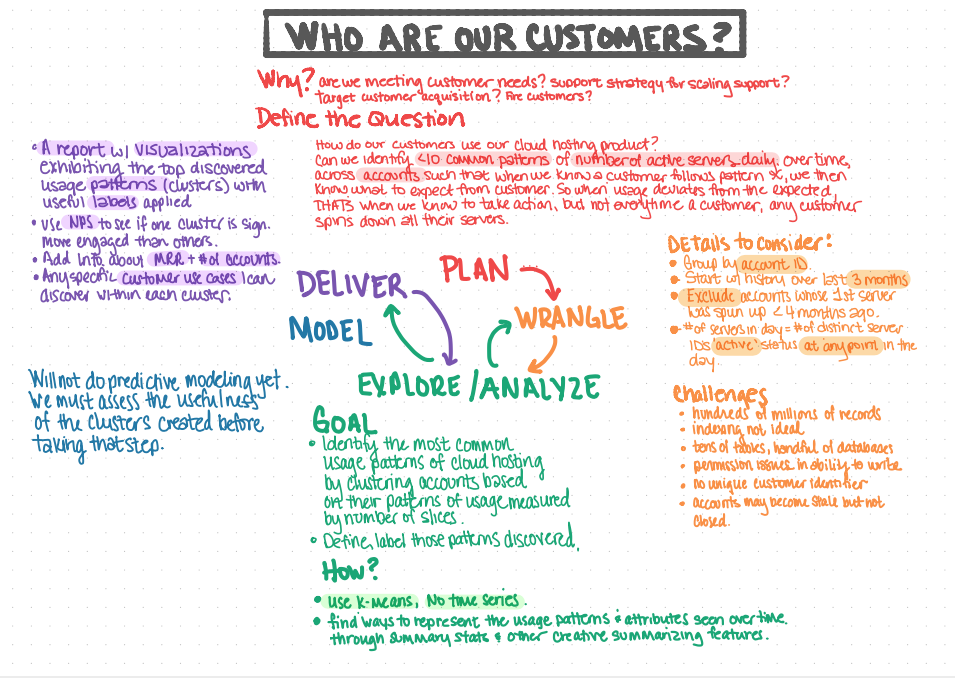

Then it was time to dive in, wrangle some ugly data, understand it, and ask and answer some questions. Clustering was a perfect methodology for answering questions I didn't know to ask, for finding patterns I didn't know to look for.

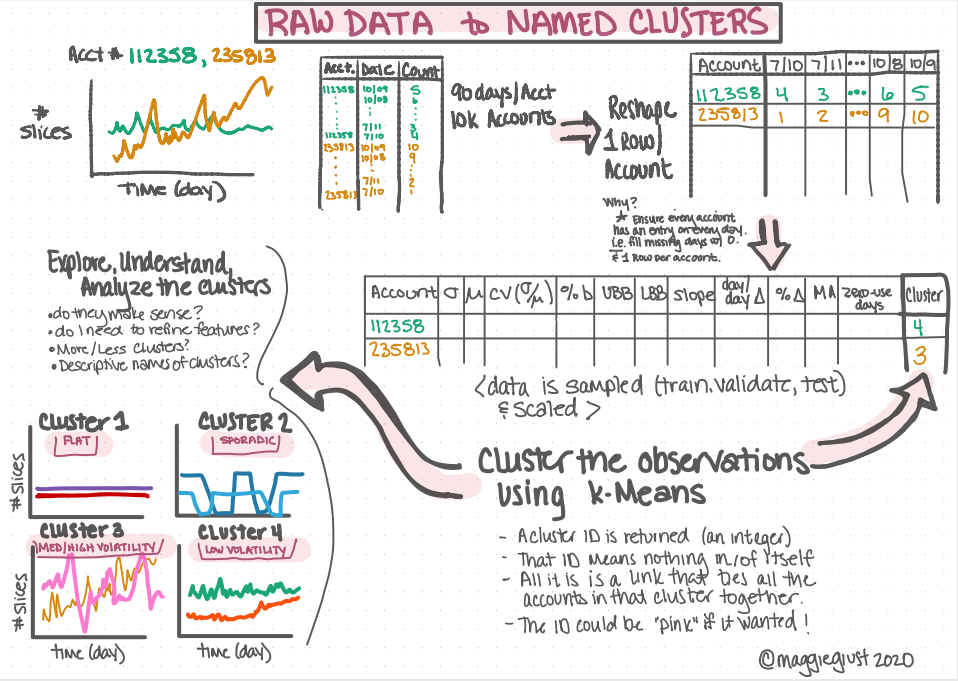

Once I had my clusters, I explored them through visualization to develop natural language descriptions of them, or labels that describe their behaviors.

**Explore & understand the clusters**

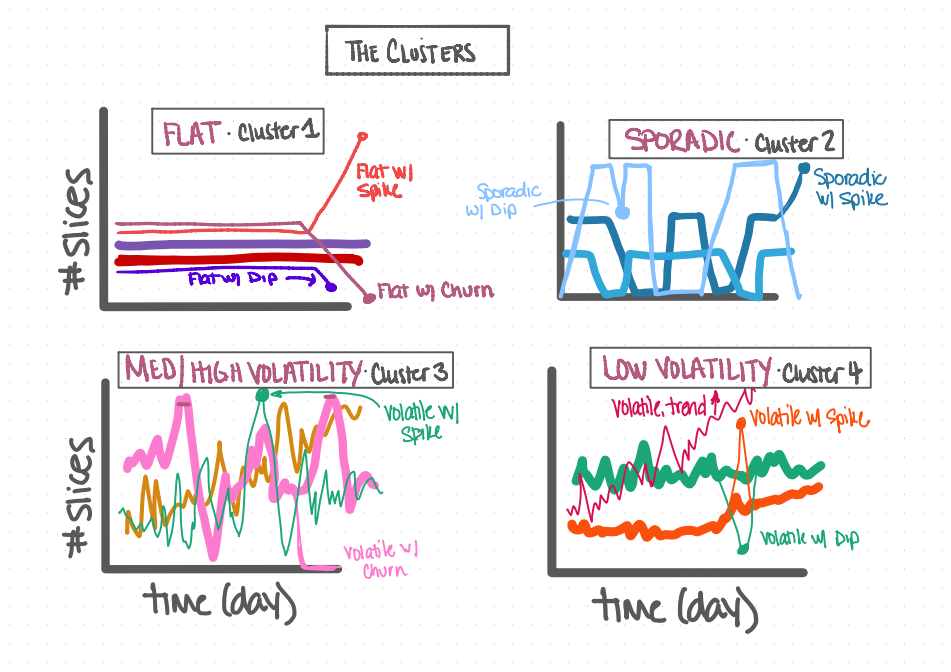

Finally, after answering the initial question (at least in one way), "Who are our cloud customers", I saw the opportunities to use this information to further benefit our mission to provide the best customer service.

**Use the clusters to go further**

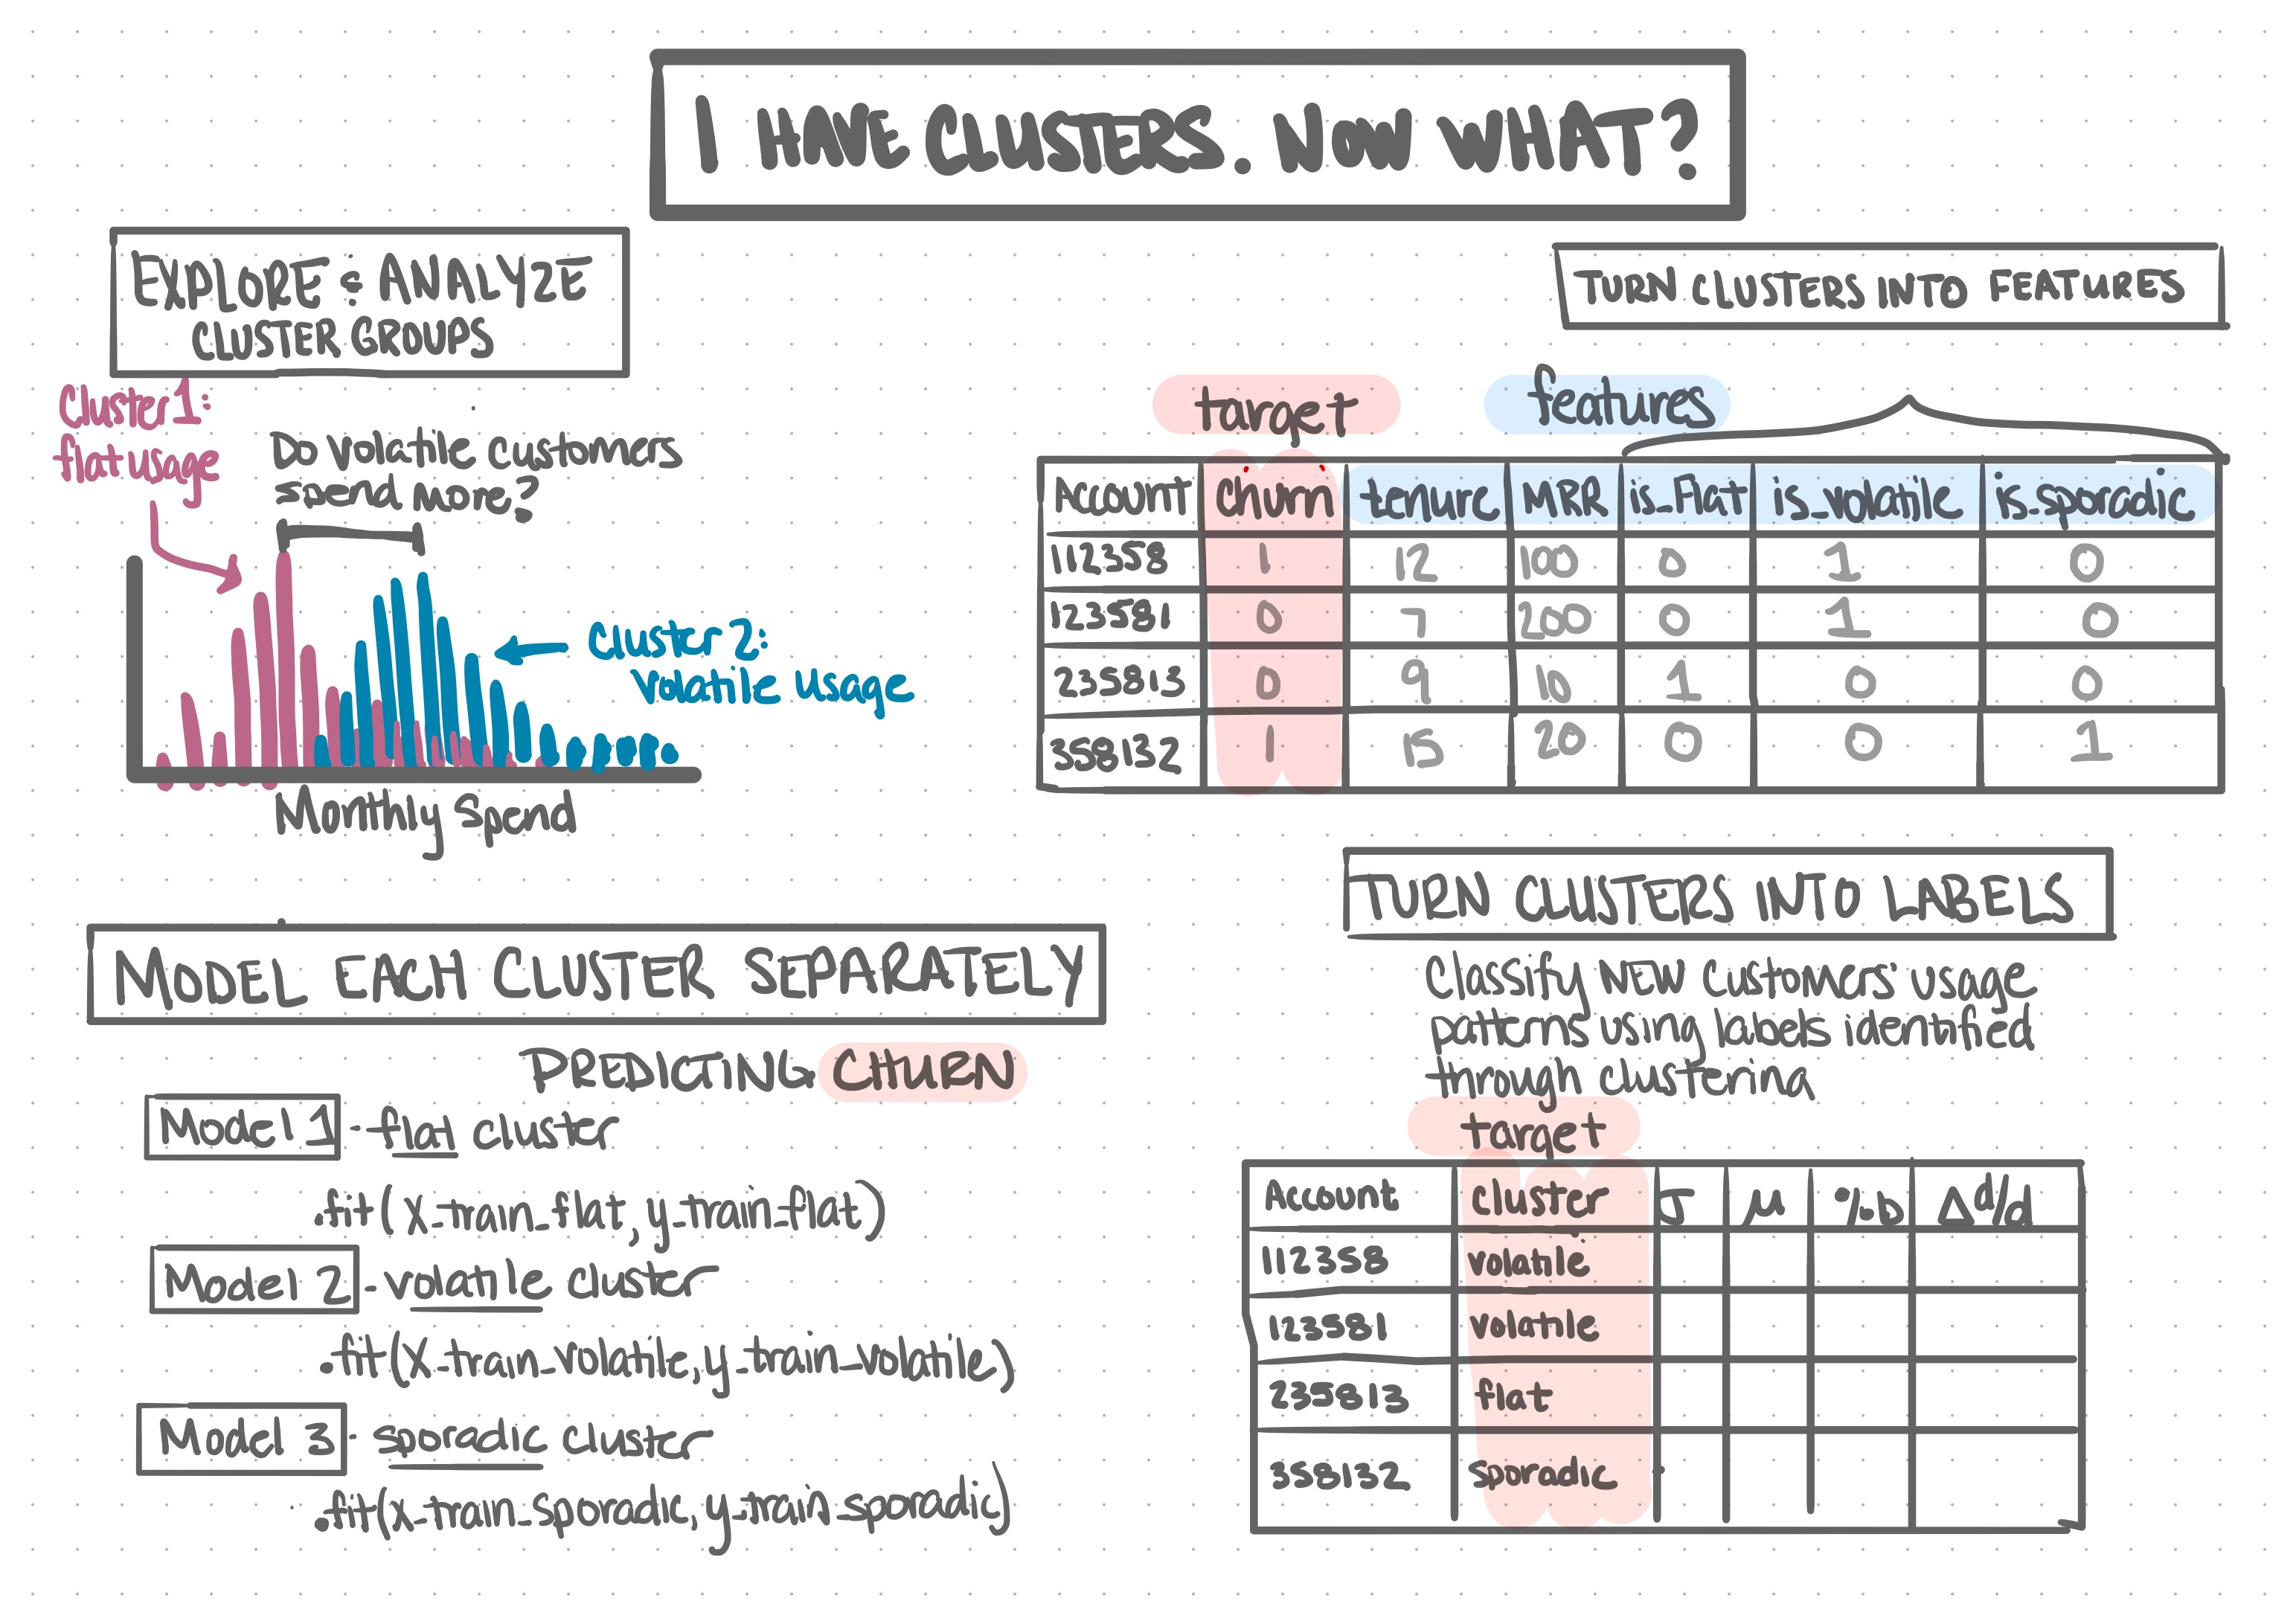

## Overview: what you can do with clusters
### Explore your Clusters

I cluster multiple variables in order to be able to explore and understand my data better. As an example, in the Zillow dataset:

1. Cluster by bedrooms, bathrooms and square feet to understand the different groups of combinations.

2. Plot 2 dimensions, such at logerror and lot size, and color by cluster id to see multiple dimensions in a single plot and understand the interaction of all these variables on your target, logerror in this case, a bit better.

3. Use the clusters to run an anova to see if there is a significant difference in the log error among these groups.

4. If there is a difference, what can we learn? What are the specs of the clusters with significantly higher or lower errors?



### Turn your Clusters into Labels
I create clusters that I then label so that I can build a model to predict which group an observation belongs in. For example, I want to classify H-E-B customers by types of items they shop for. But I don't know what the distinct groups are yet.

1. Cluster based on something like average number of items per store department per visit.

2. Review clusters through exploration to create useful labels.

3. When you have the clustering model fit, you can run predict on new data to identify which clusters new observations belong in OR, for a longer term solution, 3. Use supervised methods (regression/classification) and a training sample of your dataset (with features) with your target being labeled classes to create a model that predicts those classes.

4. After selecting the best model on train, test your model on the out-of-sample data that was already clustered (therefore it has labels) and evaluate.

5. Run the model on all data to add labels to all existing data.

6. Take some random samples to manually verify and do a little exploration to verify the new labels are doing what you expect.



### Model Each Cluster Separately
I have created clusters of customers based on their consumption of hosting products and services. I have seen that the different clusters have different drivers of churn. I would like to build a unique model predicting churn for each cluster created.

1. Cluster by services, products and monthly revenue.

2. When you have the clustering model fit, you can run predict on new data to identify which clusters new observations belong in.

3. Use supervised methods (regression/classification) and a training sample of your dataset (with features + target variable) for each unique cluster to create a model that predicts your original target variable.

### Turn your Clusters into Features
Use clusters to create new, more descriptive features. Could also reduce number of dimensions.

1. Cluster by latitude, longitude and age to get "area clusters"

2. Cluster by home and lot size to get "size clusters"

3. Get descriptive stats of the value per sqft

4. Use the standard deviation & median of the dollar per square foot for the cluster of the observation as new features (or other stats), or create dummy variables of the clusters.



### Acquire
We will acquire data from the Zillow database, property information from 2017 sales along with prediction outcomes (logerror) for single unit properties, or those with land use type id of 261.

In [1]:
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    query = '''
    select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
    from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;
    '''
    return pd.read_sql(query, get_connection('zillow'))

Run the sql query to acquire zillow data

In [2]:
df = get_zillow_data()

Look at the first 5 rows of our new dataframe, but we will transpose the view so that we can see all the columns without having to scroll. This is just for the view! The dataframe is still stored as we would expect.

*Transpose*: rotate the data so that rows become columns and the columns become rows.

In [3]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

0             1             2  \
parcelid                      1.429752e+07  1.705289e+07  1.418624e+07   
logerror                      2.559490e-02  5.561909e-02  5.382853e-03   
bathroomcnt                   3.500000e+00  1.000000e+00  2.000000e+00   
bedroomcnt                    4.000000e+00  2.000000e+00  3.000000e+00   
calculatedfinishedsquarefeet  3.100000e+03  1.465000e+03  1.243000e+03   
fips                          6.059000e+03  6.111000e+03  6.059000e+03   
latitude                      3.363493e+07  3.444927e+07  3.388617e+07   
longitude                    -1.178692e+08 -1.192815e+08 -1.178232e+08   
lotsizesquarefeet             4.506000e+03  1.264700e+04  8.432000e+03   
regionidcity                  5.357100e+04  1.309100e+04  2.141200e+04   
regionidcounty                1.286000e+03  2.061000e+03  1.286000e+03   
regionidzip                   9.697800e+04  9.709900e+04  9.707800e+04   
yearbuilt                     1.998000e+03  1.967000e+03  1.962000e+03   
structuretaxvaluedollarcnt    4.857130e+05  8.800000e+04  8.528900e+04   
taxvaluedollarcnt             1.023282e+06  4.640000e+05  5.647780e+05   
landtaxvaluedollarcnt         5.375690e+05  3.760000e+05  4.794890e+05   
taxamount                     1.101372e+04  5.672480e+03  6.488300e+03   

                                         3             4  
parcelid                      1.217790e+07  1.209508e+07  
logerror                     -1.034097e-01 -1.010962e-03  
bathroomcnt                   3.000000e+00  3.000000e+00  
bedroomcnt                    4.000000e+00  4.000000e+00  
calculatedfinishedsquarefeet  2.376000e+03  2.962000e+03  
fips                          6.037000e+03  6.037000e+03  
latitude                      3.424518e+07  3.414520e+07  
longitude                    -1.182407e+08 -1.181798e+08  
lotsizesquarefeet             1.303800e+04  6.300000e+04  
regionidcity                  3.965510e+05  4.701900e+04  
regionidcounty                3.101000e+03  3.101000e+03  
regionidzip                   9.633000e+04  9.629300e+04  
yearbuilt                     1.970000e+03  1.950000e+03  
structuretaxvaluedollarcnt    1.089180e+05  2.766840e+05  
taxvaluedollarcnt             1.451430e+05  7.733030e+05  
landtaxvaluedollarcnt         3.622500e+04  4.966190e+05  
taxamount                     1.777510e+03  9.516260e+03

In [4]:
df.shape

(52442, 17)

### Clean & Prep
1. Drop missing values: It is < 2000 observations out of 52,442, so there are plenty of observations to work with even when we drop all observations with missing values.

2. Get county names and create dummy variables with those.

3. Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

4. Remove outliers - we can study those separately at a later time.

5. Reduce features.

### 1. Drop Observations with Missing Values

Number of observations with 1 or more missing values:

In [5]:
# df.isna() will return the dataframe structure (rows & columns with names) with 'True' where value is missing 
# and 'False' where not. 

# adding .sum (df.isna().sum()) will then sum each column. Remember that False == 0 and True == 1, so summing 
# across those will ultimately give the number of Trues, or the number of cells missing, per column. 

# adding the last .sum (df.isna().sum().sum()) will then sum the results of each column. 

# NOTE: the result tells us there are AT MOST that many observations with a missing value. If is likely fewer, 
# depending on the number of observations are missing values from multiple variables. 

df.isna().sum().sum()

1720

We will drop all observations with one or more missing values,

In [6]:
df.dropna(inplace=True)


Confirm there are now no missing values.



In [7]:
df.isna().sum().sum()


0

Let's see how many rows we actually ended up dropping. From above when we first ran df.shape, we saw we had 52,442 observations.



In [8]:
print('We dropped {} rows'.format(52442-df.shape[0]))

We dropped 1529 rows


2. Get county names and create dummy variables with those.

Replace fips/county with the county name and create dummy vars for county, or split into 3 different dataframes.

- 6037: Los Angeles County

- 6059: Orange County

- 6111: Ventura County

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697


In [9]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [10]:
df = get_counties()
df.head().T

0             1             2  \
parcelid                      1.429752e+07  1.705289e+07  1.418624e+07   
logerror                      2.559490e-02  5.561909e-02  5.382853e-03   
bathroomcnt                   3.500000e+00  1.000000e+00  2.000000e+00   
bedroomcnt                    4.000000e+00  2.000000e+00  3.000000e+00   
calculatedfinishedsquarefeet  3.100000e+03  1.465000e+03  1.243000e+03   
fips                          6.059000e+03  6.111000e+03  6.059000e+03   
latitude                      3.363493e+07  3.444927e+07  3.388617e+07   
longitude                    -1.178692e+08 -1.192815e+08 -1.178232e+08   
lotsizesquarefeet             4.506000e+03  1.264700e+04  8.432000e+03   
regionidcity                  5.357100e+04  1.309100e+04  2.141200e+04   
regionidzip                   9.697800e+04  9.709900e+04  9.707800e+04   
yearbuilt                     1.998000e+03  1.967000e+03  1.962000e+03   
structuretaxvaluedollarcnt    4.857130e+05  8.800000e+04  8.528900e+04   
taxvaluedollarcnt             1.023282e+06  4.640000e+05  5.647780e+05   
landtaxvaluedollarcnt         5.375690e+05  3.760000e+05  4.794890e+05   
taxamount                     1.101372e+04  5.672480e+03  6.488300e+03   
LA                            0.000000e+00  0.000000e+00  0.000000e+00   
Orange                        1.000000e+00  0.000000e+00  1.000000e+00   
Ventura                       0.000000e+00  1.000000e+00  0.000000e+00   

                                         3             4  
parcelid                      1.217790e+07  1.209508e+07  
logerror                     -1.034097e-01 -1.010962e-03  
bathroomcnt                   3.000000e+00  3.000000e+00  
bedroomcnt                    4.000000e+00  4.000000e+00  
calculatedfinishedsquarefeet  2.376000e+03  2.962000e+03  
fips                          6.037000e+03  6.037000e+03  
latitude                      3.424518e+07  3.414520e+07  
longitude                    -1.182407e+08 -1.181798e+08  
lotsizesquarefeet             1.303800e+04  6.300000e+04  
regionidcity                  3.965510e+05  4.701900e+04  
regionidzip                   9.633000e+04  9.629300e+04  
yearbuilt                     1.970000e+03  1.950000e+03  
structuretaxvaluedollarcnt    1.089180e+05  2.766840e+05  
taxvaluedollarcnt             1.451430e+05  7.733030e+05  
landtaxvaluedollarcnt         3.622500e+04  4.966190e+05  
taxamount                     1.777510e+03  9.516260e+03  
LA                            1.000000e+00  1.000000e+00  
Orange                        0.000000e+00  0.000000e+00  
Ventura                       0.000000e+00  0.000000e+00

Let's confirm we have expected results

In [11]:
print("LA County Verified: ", df[df.fips==6037]['fips'].count() == df.LA.sum())
print("Orange County Verified: ", df[df.fips==6059]['fips'].count() == df.Orange.sum())
print("Ventura County Verified: ", df[df.fips==6111]['fips'].count() == df.Ventura.sum())

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


3. Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

- **age**: 2017 - year built.

- **tax_rate**: taxamount/taxvaluedollarcnt fields (total, land & structure). We can then remove taxamount and taxvaluedollarcnt, and will keep taxrate, tructuretaxvaluedollarcnt, and landtaxvalue.

- **acres**: lotsizesquarefeet/43560

- **structure_dollar_per_sqft**: structure tax value/finished square feet

- ***land_dollar_per_sqft**: land tax value/lot size square feet

- **bed_bath_ratio**: bedroomcnt/bathroomcnt

- **cola**: city of LA, LA has the largest number of records (across single cities) with a very wide range in values, so we I am creating a boolean feature for city of LA. That will help the model for LA county.

In [12]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df

In [13]:
df = create_features(df)
df.head().T

0             1             2  \
parcelid                      1.429752e+07  1.705289e+07  1.418624e+07   
logerror                      2.559490e-02  5.561909e-02  5.382853e-03   
bathroomcnt                   3.500000e+00  1.000000e+00  2.000000e+00   
bedroomcnt                    4.000000e+00  2.000000e+00  3.000000e+00   
calculatedfinishedsquarefeet  3.100000e+03  1.465000e+03  1.243000e+03   
fips                          6.059000e+03  6.111000e+03  6.059000e+03   
latitude                      3.363493e+07  3.444927e+07  3.388617e+07   
longitude                    -1.178692e+08 -1.192815e+08 -1.178232e+08   
lotsizesquarefeet             4.506000e+03  1.264700e+04  8.432000e+03   
regionidcity                  5.357100e+04  1.309100e+04  2.141200e+04   
regionidzip                   9.697800e+04  9.709900e+04  9.707800e+04   
yearbuilt                     1.998000e+03  1.967000e+03  1.962000e+03   
structuretaxvaluedollarcnt    4.857130e+05  8.800000e+04  8.528900e+04   
taxvaluedollarcnt             1.023282e+06  4.640000e+05  5.647780e+05   
landtaxvaluedollarcnt         5.375690e+05  3.760000e+05  4.794890e+05   
taxamount                     1.101372e+04  5.672480e+03  6.488300e+03   
LA                            0.000000e+00  0.000000e+00  0.000000e+00   
Orange                        1.000000e+00  0.000000e+00  1.000000e+00   
Ventura                       0.000000e+00  1.000000e+00  0.000000e+00   
age                           1.900000e+01  5.000000e+01  5.500000e+01   
age_bin                       1.330000e-01  3.330000e-01  4.000000e-01   
taxrate                       1.076313e+00  1.222517e+00  1.148823e+00   
acres                         1.034435e-01  2.903352e-01  1.935721e-01   
acres_bin                     1.000000e-01  3.000000e-01  2.000000e-01   
sqft_bin                      7.000000e-01  3.000000e-01  2.000000e-01   
structure_dollar_per_sqft     1.566816e+02  6.006826e+01  6.861545e+01   
structure_dollar_sqft_bin     5.000000e-01  2.000000e-01  2.000000e-01   
land_dollar_per_sqft          1.193007e+02  2.973037e+01  5.686539e+01   
lot_dollar_sqft_bin           5.000000e-01  3.000000e-01  4.000000e-01   
bath_bed_ratio                8.750000e-01  5.000000e-01  6.666667e-01   
cola                          0.000000e+00  0.000000e+00  0.000000e+00   

                                         3             4  
parcelid                      1.217790e+07  1.209508e+07  
logerror                     -1.034097e-01 -1.010962e-03  
bathroomcnt                   3.000000e+00  3.000000e+00  
bedroomcnt                    4.000000e+00  4.000000e+00  
calculatedfinishedsquarefeet  2.376000e+03  2.962000e+03  
fips                          6.037000e+03  6.037000e+03  
latitude                      3.424518e+07  3.414520e+07  
longitude                    -1.182407e+08 -1.181798e+08  
lotsizesquarefeet             1.303800e+04  6.300000e+04  
regionidcity                  3.965510e+05  4.701900e+04  
regionidzip                   9.633000e+04  9.629300e+04  
yearbuilt                     1.970000e+03  1.950000e+03  
structuretaxvaluedollarcnt    1.089180e+05  2.766840e+05  
taxvaluedollarcnt             1.451430e+05  7.733030e+05  
landtaxvaluedollarcnt         3.622500e+04  4.966190e+05  
taxamount                     1.777510e+03  9.516260e+03  
LA                            1.000000e+00  1.000000e+00  
Orange                        0.000000e+00  0.000000e+00  
Ventura                       0.000000e+00  0.000000e+00  
age                           4.700000e+01  6.700000e+01  
age_bin                       3.330000e-01  4.660000e-01  
taxrate                       1.224661e+00  1.230599e+00  
acres                         2.993113e-01  1.446281e+00  
acres_bin                     3.000000e-01  5.000000e-01  
sqft_bin                      5.000000e-01  6.000000e-01  
structure_dollar_per_sqft     4.584091e+01  9.341121e+01  
structure_dollar_sqft_bin     1.000000e-01  3.000000e-01  
land_dollar_per_sqft

4. Remove Outliers

What do the distributions look like currently?

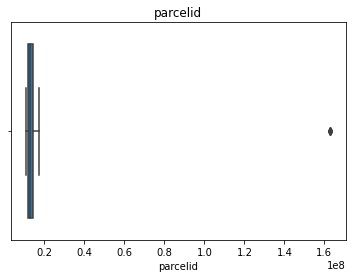

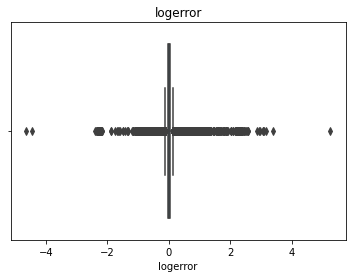

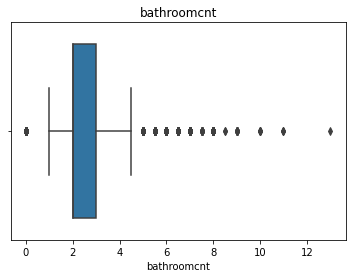

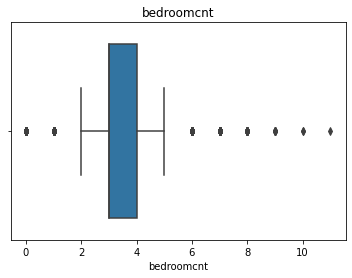

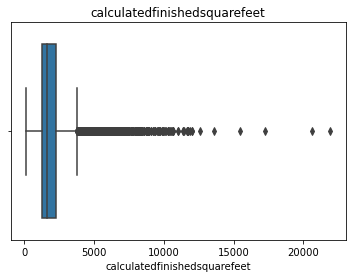

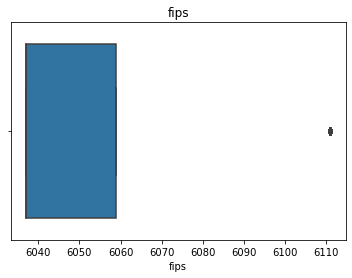

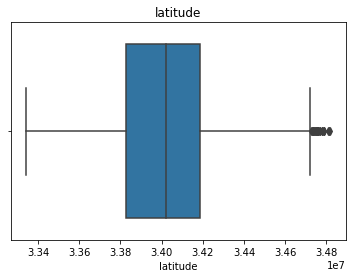

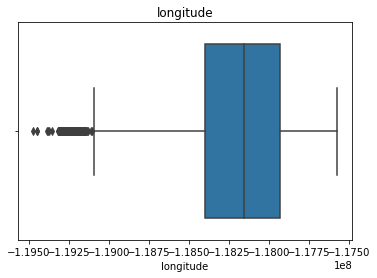

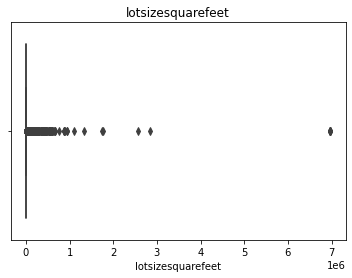

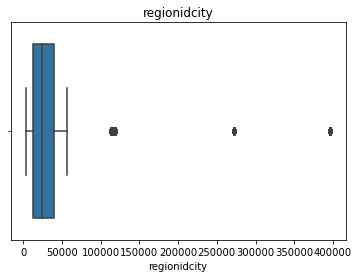

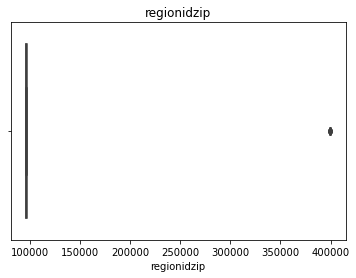

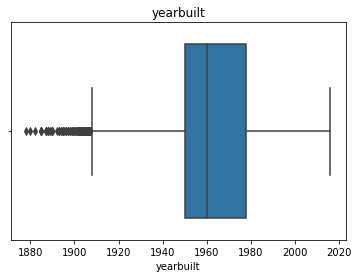

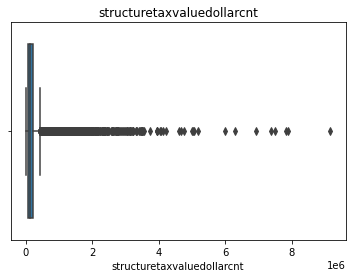

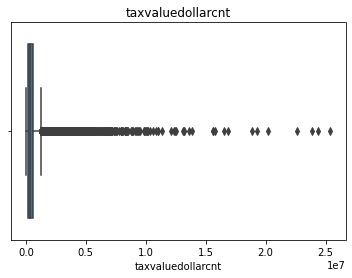

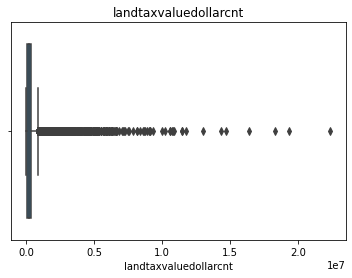

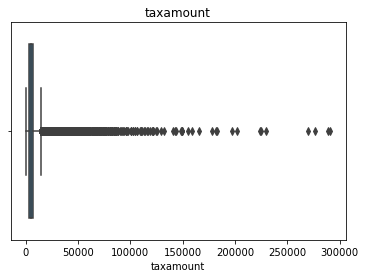

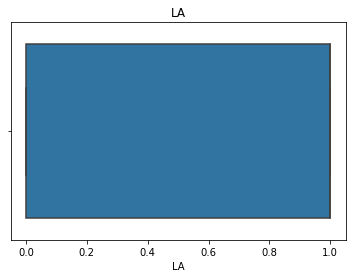

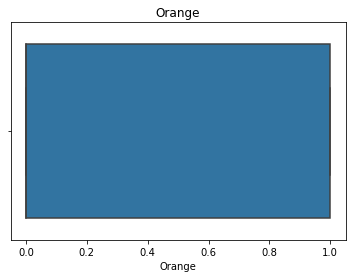

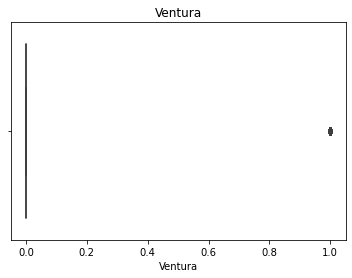

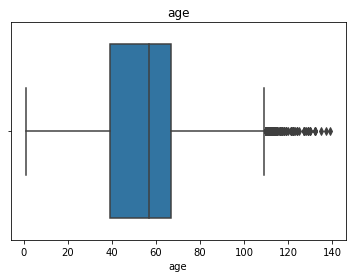

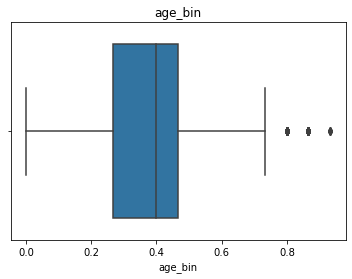

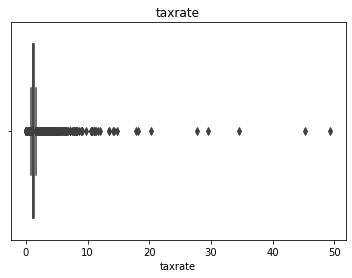

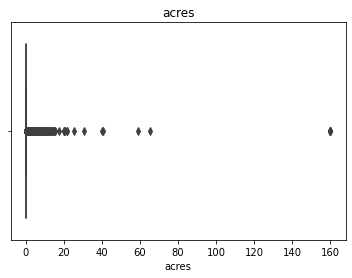

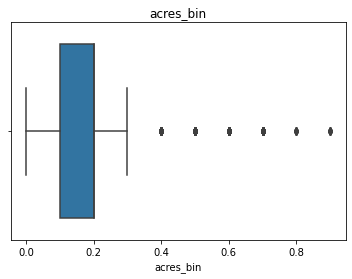

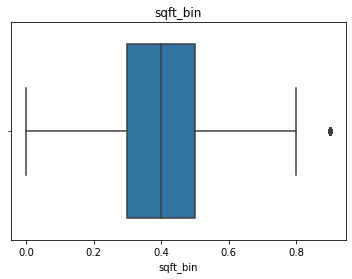

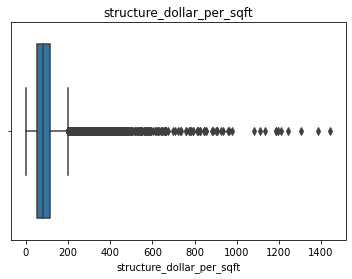

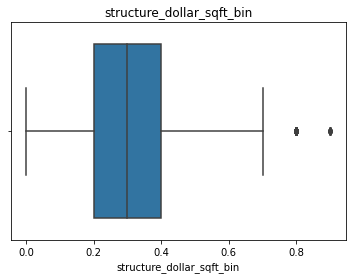

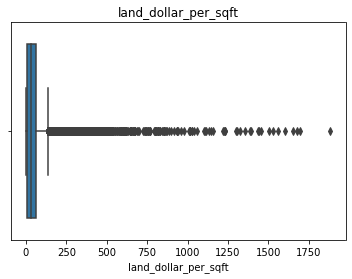

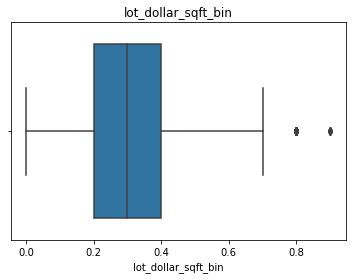

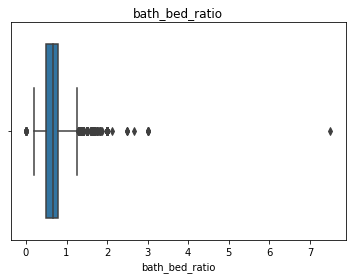

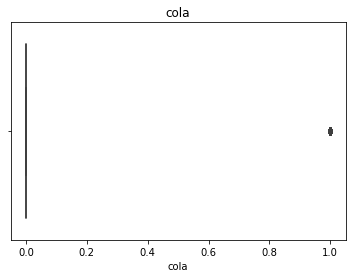

In [14]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

1. Remove extremes in bedrooms and baths, we will keeps homes with between 1 and 7 baths, between 0 and 7 bedrooms

2. There is an error in zip, so we will remove those whose zips are invalid numbers (> 99999).

3. remove square feet > 10000 for now

4. remove lot size (acres) > 20 for now

5. What is this tax rate of almost 50%?? Remove tax rate > 10% for now.

In [15]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
               (df.regionidzip < 100000) & 
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 20) &
               (df.calculatedfinishedsquarefeet < 10000) & 
               (df.taxrate < 10)
              )]

In [16]:
df = remove_outliers()

# Now that the most extreme outliers have been removed, let's look at the summary statistics of each numeric field. 
df.describe().T

count          mean           std  \
parcelid                      50677.0  1.296909e+07  2.292824e+06   
logerror                      50677.0  1.796359e-02  1.738460e-01   
bathroomcnt                   50677.0  2.279042e+00  9.699697e-01   
bedroomcnt                    50677.0  3.296683e+00  9.114688e-01   
calculatedfinishedsquarefeet  50677.0  1.895669e+03  9.291601e+02   
fips                          50677.0  6.049254e+03  2.115866e+01   
latitude                      50677.0  3.402033e+07  2.720810e+05   
longitude                     50677.0 -1.181937e+08  3.560882e+05   
lotsizesquarefeet             50677.0  9.754763e+03  2.016309e+04   
regionidcity                  50677.0  3.354932e+04  4.928741e+04   
regionidzip                   50677.0  9.656818e+04  4.230091e+02   
yearbuilt                     50677.0  1.962956e+03  2.277915e+01   
structuretaxvaluedollarcnt    50677.0  1.887479e+05  2.166908e+05   
taxvaluedollarcnt             50677.0  5.122470e+05  6.416816e+05   
landtaxvaluedollarcnt         50677.0  3.234991e+05  4.796979e+05   
taxamount                     50677.0  6.225010e+03  7.378617e+03   
LA                            50677.0  6.446120e-01  4.786355e-01   
Orange                        50677.0  2.700831e-01  4.440069e-01   
Ventura                       50677.0  8.530497e-02  2.793377e-01   
age                           50677.0  5.404393e+01  2.277915e+01   
age_bin                       50677.0  3.896172e-01  1.541535e-01   
taxrate                       50677.0  1.324792e+00  3.570381e-01   
acres                         50677.0  2.239386e-01  4.628809e-01   
acres_bin                     50677.0  1.669712e-01  1.022612e-01   
sqft_bin                      50677.0  3.917714e-01  1.856603e-01   
structure_dollar_per_sqft     50677.0  8.993532e+01  5.896127e+01   
structure_dollar_sqft_bin     50677.0  2.776625e-01  1.463621e-01   
land_dollar_per_sqft          50677.0  4.833533e+01  7.200902e+01   
lot_dollar_sqft_bin           50677.0  2.897113e-01  1.288436e-01   
bath_bed_ratio                50677.0  6.955937e-01  2.342354e-01   
cola                          50677.0  2.215403e-01  4.152874e-01   

                                       min           25%           50%  \
parcelid                      1.071186e+07  1.153139e+07  1.259430e+07   
logerror                     -4.655420e+00 -2.476254e-02  6.844754e-03   
bathroomcnt                   1.000000e+00  2.000000e+00  2.000000e+00   
bedroomcnt                    1.000000e+00  3.000000e+00  3.000000e+00   
calculatedfinishedsquarefeet  1.520000e+02  1.265000e+03  1.649000e+03   
fips                          6.037000e+03  6.037000e+03  6.037000e+03   
latitude                      3.334085e+07  3.382684e+07  3.401962e+07   
longitude                    -1.194753e+08 -1.183968e+08 -1.181516e+08   
lotsizesquarefeet             2.360000e+02  5.568000e+03  6.810000e+03   
regionidcity                  3.491000e+03  1.244700e+04  2.481200e+04   
regionidzip                   9.598200e+04  9.620400e+04  9.641500e+04   
yearbuilt                     1.878000e+03  1.950000e+03  1.960000e+03   
structuretaxvaluedollarcnt    1.480000e+02  7.660700e+04  1.301340e+05   
taxvaluedollarcnt             3.254000e+03  1.917500e+05  3.692810e+05   
landtaxvaluedollarcnt         2.250000e+03  7.420100e+04  2.163680e+05   
taxamount                     4.918000e+01  2.630730e+03  4.590130e+03   
LA                            0.000000e+00  0.000000e+00  1.000000e+00   
Orange                        0.000000e+00  0.000000e+00  0.000000e+00   
Ventura                       0.000000e+00  0.000000e+00  0.000000e+00   
age                           1.000000e+00  3.900000e+01  5.700000e+01   
age_bin                       0.000000e+00  2.660000e-01  4.000000e-01   
taxrate                       9.372442e-03  1.163545e+00  1.232257e+00   
acres                         5.417815e-03  1.278237e-01  1.563361e-01   
acres_bin                     0.000000e+00  1.0

5. Drop Columns

For now, I will focus on the most difficult and diverse county, LA county. I'll add the others in after I see what I can find.

I'm not sure where I will use bins and where I will use actual values, so for now I think i'll go with bins and see what happens.

I will remove the following variables:

- parcelid: 
    - can tie back to parcels later

- bedroomcnt: 
    - info captured in bed_bath_ratio + bathroomcnt

- taxrate, taxamount, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt: 
    - info captured in tax_bin + structure_dollar_per_sqft + land_dollar_per_sqft + acres

- yearbuilt: 
    - info captured in age

- lotsizesquarefeet: 
    - info captured in acres

- regionidcity: 
    - using boolean of whether in city of LA or not

- regionidzip: 
    - not using at this time

- LA, Orange, Ventura: 
    - will look at LA county only right now.

In [17]:
df_la = df[df.LA == 1].drop(columns = ['parcelid', 'bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 'fips', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 

In [18]:
print(df_la.shape)

(32667, 15)


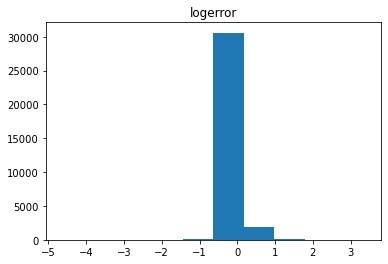

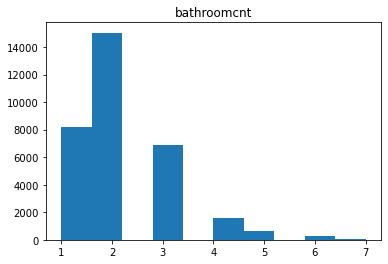

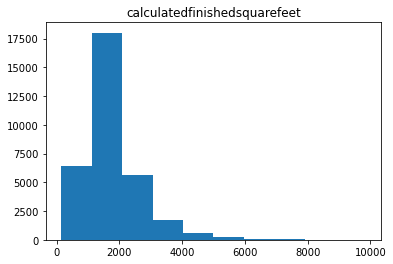

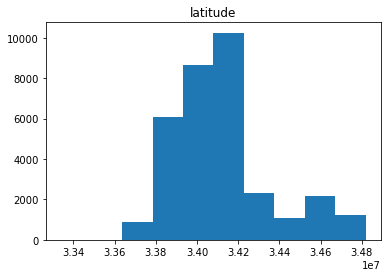

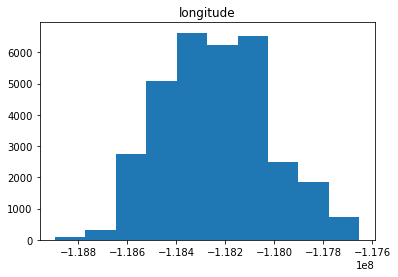

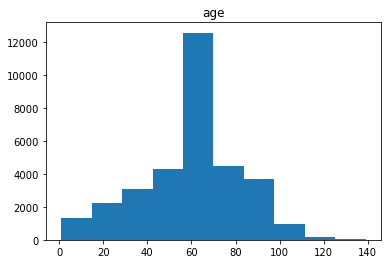

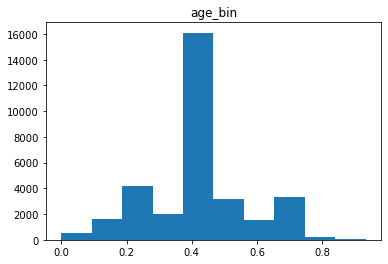

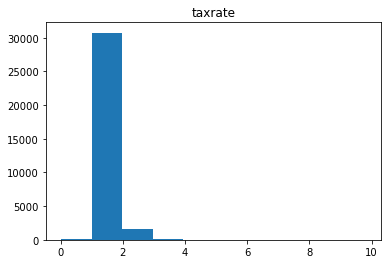

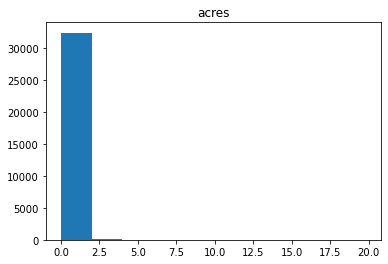

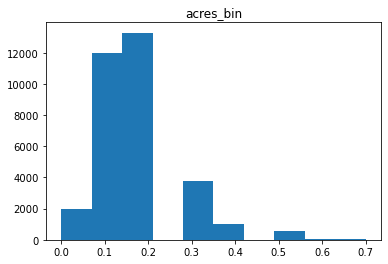

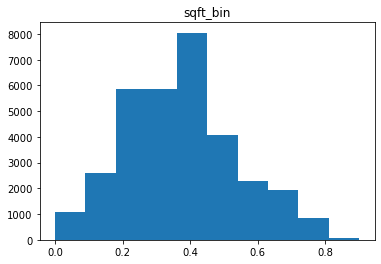

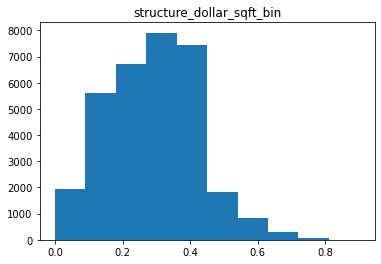

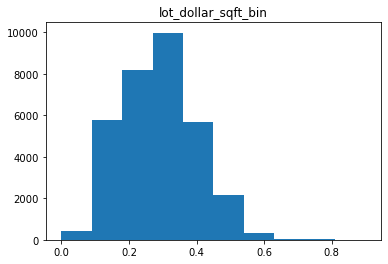

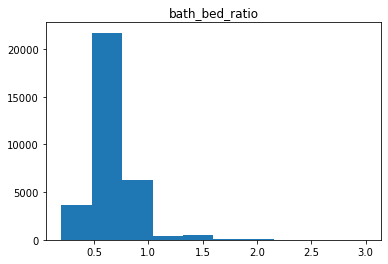

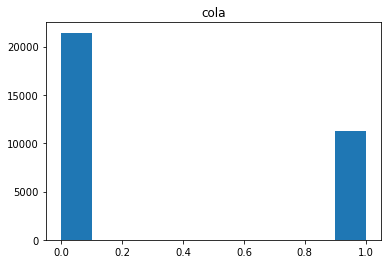

In [19]:
for col in df_la.columns:
    plt.hist(df_la[col])
    plt.title(col)
    plt.show()

linear scalers: latitude, longitude, bathroomcnt, taxrate

no scaling needed: cola, bath_bed_ratio, acres_bin, lot_dollar_sqft_bin, structure_dollar_sqft_bin, sqft_bin, age_bin

Split into train, validate & test

In [20]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions

In [21]:
partitions = split(df_la, target_var='logerror')

Let's take a quick look at the interaction of all the variables. Remember, a pairplot can take a long time to run. It depends on the number of observations and number of variables you have in your dataframe.

In [22]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train

In [23]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    11187
(0.05, 0.2]       3081
(-0.2, -0.05]     2626
(0.2, 4.0]         894
(-5.0, -0.2]       505
Name: logerror_bins, dtype: int64

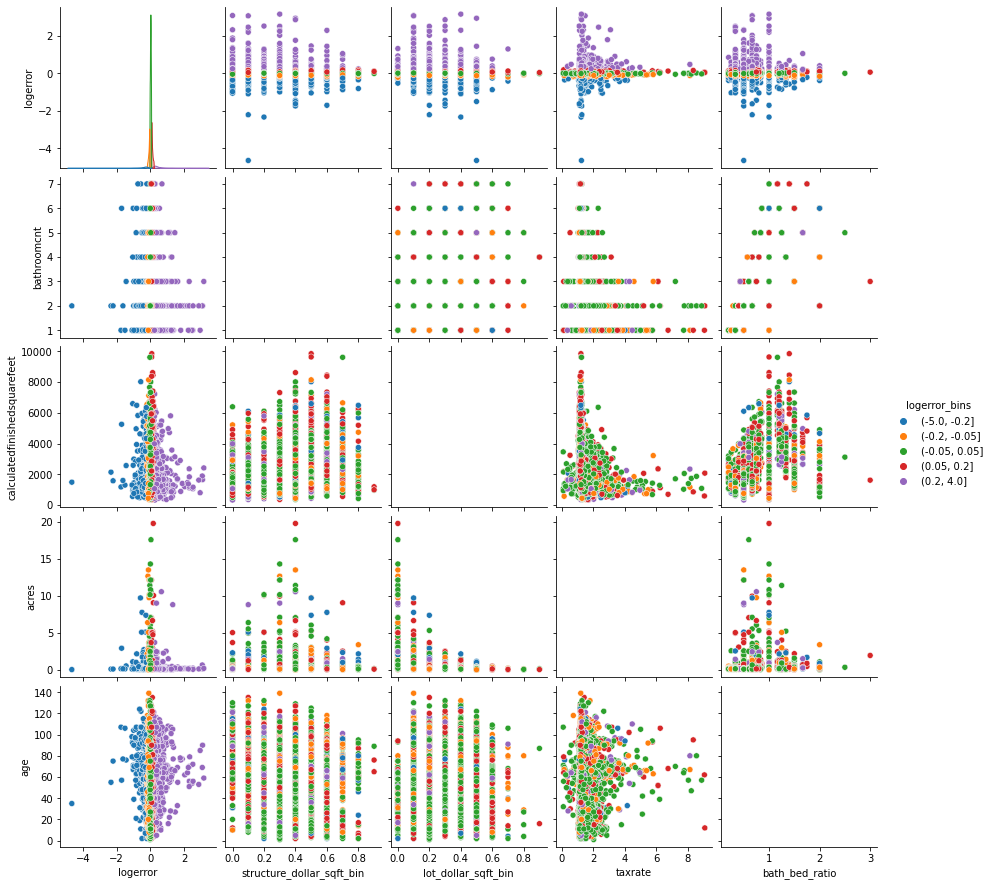

In [24]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

**Takeaways?**

Error is greatest for the homes that are 50-80 years old. Error is greatest for the properties sitting on smaller land. Error is greatest for properties with fewer square feet. Error is greatest for properties with 1 or 2 bathrooms. Error is greatest for locations in the southern to center (S-N) of the county. Error is greatest for locations in the center (W-E) of the county as opposed to on the coastline or far eastern edge. Error is greatest and positive for the lower structure dollar per square feet, indicating the properties tax value is underrepresenting the future sale price. Error is greatest the the lower and more common tax rates. Error is greatest for homes where the number of bathrooms <= number of bedrooms.



**Scale**

I will scale all of our features using MinMaxScaler

In [25]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [26]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()

bathroomcnt  calculatedfinishedsquarefeet      latitude     longitude  \
count  18293.000000                  18293.000000  1.829300e+04  1.829300e+04   
mean       2.157656                   1778.312469  3.411769e+07 -1.182377e+08   
std        0.992574                    884.836252  2.312723e+05  2.155461e+05   
min        1.000000                    326.000000  3.334085e+07 -1.188928e+08   
25%        1.000000                   1190.000000  3.395640e+07 -1.183979e+08   
50%        2.000000                   1542.000000  3.409118e+07 -1.182402e+08   
75%        3.000000                   2114.000000  3.420286e+07 -1.180971e+08   
max        7.000000                   9848.000000  3.480696e+07 -1.176539e+08   

                age       age_bin       taxrate         acres     acres_bin  \
count  18293.000000  18293.000000  18293.000000  18293.000000  18293.000000   
mean      60.488985      0.432158      1.393239      0.240972      0.174919   
std       22.442030      0.151501      0.397296      0.536560      0.100282   
min        1.000000      0.000000      0.079206      0.020868      0.000000   
25%       50.000000      0.333000      1.213394      0.130808      0.100000   
50%       63.000000      0.466000      1.263226      0.157966      0.200000   
75%       71.000000      0.533000      1.429257      0.203719      0.200000   
max      139.000000      0.933000      9.091901     19.796350      0.700000   

           sqft_bin  structure_dollar_sqft_bin  lot_dollar_sqft_bin  \
count  18293.000000               18293.000000         18293.000000   
mean       0.364298                   0.274624             0.270404   
std        0.186127                   0.150027             0.124927   
min        0.000000                   0.000000             0.000000   
25%        0.200000                   0.200000             0.200000   
50%        0.400000                   0.300000             0.300000   
75%        0.500000                   0.400000             0.400000   
max        0.900000                   0.900000             0.900000   

       bath_bed_ratio          cola  scaled_latitude  scaled_longitude  \
count    18293.000000  18293.000000     18293.000000      18293.000000   
mean         0.678904      0.345269         0.529866          0.528803   
std          0.240164      0.475469         0.157746          0.173980   
min          0.200000      0.000000         0.000000          0.000000   
25%          0.500000      0.000000         0.419850          0.399509   
50%          0.666667      0.000000         0.511788          0.526780   
75%          0.750000      1.000000         0.587960          0.642304   
max          3.000000      1.000000         1.000000          1.000000   

       scaled_bathroomcnt  scaled_taxrate  
count        18293.000000    18293.000000  
mean             0.192943        0.145798  
std              0.165429        0.044082  
min              0.000000        0.000000  
25%              0.000000        0.125843  
50%              0.166667        0.131372  
75%              0.333333        0.149794  
max              1.000000        1.000000

### Create Meaningful Clusters

**Brainstorming**

As I think about where it's difficult to predict housing prices, I think about areas where price and condition of homes vary drastically. This is generally in areas with older homes. So, how can we increase the information we have about those areas so that estimating the condition, and therefore the price, can be more accurate? There are so many ways to go about this, and who knows what will work best until we start trying them out. One idea I had was figure out a way to identify neighborhoods that are similar. Neighborhoods, in terms of the data available through the field regionidneighborhood, have many problems. The primary challenge is that so much of the data is missing. Secondly, there are many areas without defined neighborhoods. And the final point I'll mention (though there are more), is that there are so many neighborhoods that I wouldn't have to computing power to model each neighborhood separately! There is a way to do this, I'm sure, but that is going to wait until an iteration much in the future, and when it's possible to find the missing neighborhoods.

So, all of that said, I want to find a way to cluster properties at a higher level than neighborhood and zip code in some cases, and can span both geographic areas.

What if we could predict the error using the variance or standard deviation of the property assessed values of similar neighborhoods? Large standard deviation leads to larger errors. If we cluster by latitude, longitude and age maybe we can get city segments that were developed closer in time to one another, at a level higher than zip code and neighborhood. And maybe it will help separate terrain a bit, like coast vs mountains. We can then get basic statistics of dollar/sqft and lot/sqft of those areas and use those statistics as features. So we will use the clusters to extract statistics that describe them, and use those stats as features.

I could also try clustering sizes. Acres, square feet, and location, e.g.

### Area Clusters

Cluster with a focus on areas: using latitude, longitude and age.

1. Find K: evaluate best k using elbow method and analyzing the change in sse.

2. Create kmeans object & fit using training data.

3. Get centroids of each cluster for each variable.

4. Label observations with cluster id and append centroid values to each X dataframe.

In [27]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)

Step 1: Evaluate k running through different values of k on X_train (the first dataframe in our list, X) and comparing the Sum of Squared Errors, the change in SSE from one k to the next, and the percent change from one k to the next.

In [28]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

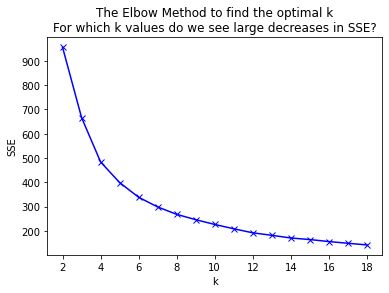

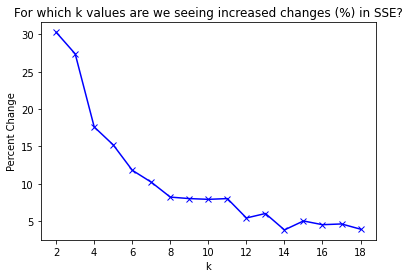

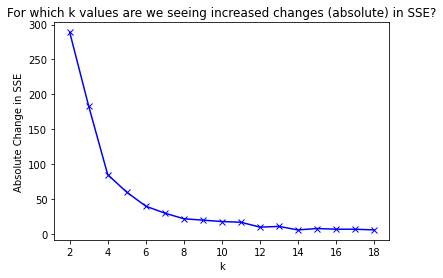

k         sse  delta  pct_delta
0    2  955.645507  289.0       30.3
1    3  666.230558  183.0       27.4
2    4  483.656104   85.0       17.6
3    5  398.680945   60.0       15.2
4    6  338.260458   40.0       11.8
5    7  298.397424   30.0       10.2
6    8  267.953230   22.0        8.2
7    9  245.994566   20.0        8.0
8   10  226.342362   18.0        7.9
9   11  208.550521   17.0        8.0
10  12  191.950621   10.0        5.4
11  13  181.651928   11.0        6.0
12  14  170.670711    6.0        3.8
13  15  164.233575    8.0        5.0
14  16  155.949871    7.0        4.5
15  17  148.933937    7.0        4.6
16  18  142.148041    6.0        3.9

In [29]:
find_k(X[0], cluster_vars, k_range)

We will try k=5, as we really need more clusters to make this meaningful.

So let's create our clusters.

In [30]:
k = 5
# as reminders: 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'

Step 2: Create kmeans object & fit using training data.

In [31]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [32]:
kmeans = create_clusters(X[0], k, cluster_vars)

Step 3: Get centroids of each cluster for each variable.

In [33]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [34]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

Step 4: Label observations with cluster id and append centroid values to each X dataframe.

In [35]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X

In [36]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [37]:
pd.DataFrame(X[0].groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())

area_cluster
area_cluster centroid_scaled_latitude centroid_scaled_longitude centroid_age_bin              
0            0.486174                 0.777381                  0.396247                  3348
1            0.592608                 0.326046                  0.376627                  4641
2            0.493736                 0.499566                  0.622930                  3823
3            0.872779                 0.617564                  0.236948                  2018
4            0.372783                 0.537190                  0.441747                  4463

I'm not really sure I see much difference across the clusters when looking at the different values. Further exploration needed.

**Size Clusters**

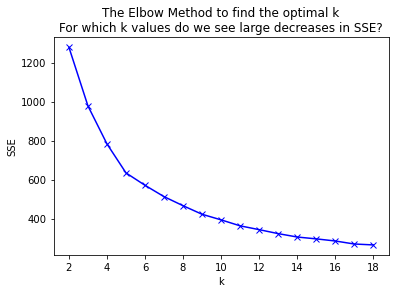

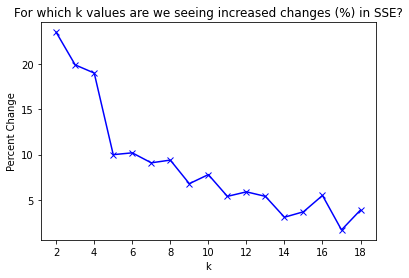

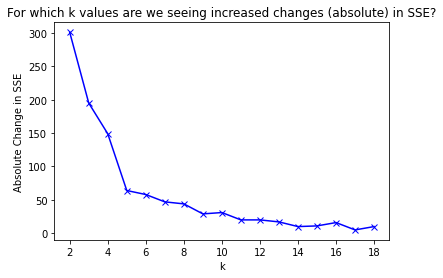

k          sse  delta  pct_delta
0    2  1278.318261  301.0       23.5
1    3   977.411915  195.0       19.9
2    4   782.541071  149.0       19.0
3    5   633.864424   64.0       10.0
4    6   570.286914   58.0       10.2
5    7   512.103892   47.0        9.1
6    8   465.594083   44.0        9.4
7    9   421.689117   29.0        6.8
8   10   392.991601   31.0        7.8
9   11   362.391729   20.0        5.4
10  12   342.841246   20.0        5.9
11  13   322.460063   17.0        5.4
12  14   305.072476   10.0        3.1
13  15   295.519925   11.0        3.7
14  16   284.718397   16.0        5.5
15  17   269.190732    5.0        1.7
16  18   264.540750   10.0        3.9

In [38]:
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)

In [39]:
k=7
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

Let's look at our cluster sizes and centroids across variables.

In [40]:
X_train = X[0].iloc[:,0:27]

In [41]:
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin',
                              'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())

area_cluster
size_cluster centroid_scaled_bathroomcnt centroid_sqft_bin centroid_acres_bin centroid_bath_bed_ratio              
0            0.004878                    0.174629          0.123503           0.424621                         4442
1            0.626228                    0.743878          0.297166           1.049738                          882
2            0.166784                    0.342274          0.168870           0.619892                         7125
3            0.333549                    0.494621          0.210305           0.999870                         1543
4            0.142491                    0.239249          0.138567           1.000000                         1172
5            0.335695                    0.560893          0.223521           0.713149                         2823
6            0.450436                    0.544444          0.222222           1.511166                          306

Price Clusters

Your turn to try it out. Create clusters related to price/value using `taxrate`, `structure_dollar_sqft_bin`, `lot_dollar_sqft_bin`.



### Use our clusters
What do we do now?

1. Explore our clusters

2. Turn clusters into features

3. Model each cluster separately

4. Turn clusters into labels



### Explore our Clusters
We will use the unscaled version of X_train along with y_train to explore.

**Area Clusters**

First, let's explore the area clusters, `area_cluster`, which were created using latitude, longitude and age. We can explore with respect to the variables used to cluster to try to identify the differences between the clusters and appropriately change the cluster ID's into meaninful labels. We can also explore the clusters with respect to the target variable to see if there are any differences in error across the clusters. Finally, we can explore the clusters with respect to other independent variables. are we adding new information to our dataset with these clusters that can help us predict our target?

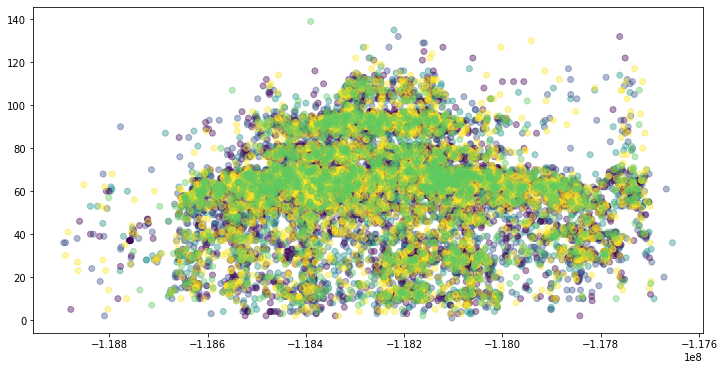

In [42]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X_train.age, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

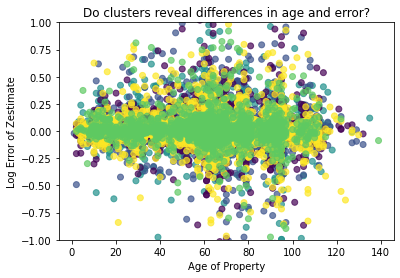

In [43]:
y_train = partitions[-3]

plt.scatter(y=y_train.logerror, x=X_train.age, c=X_train.area_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

(-1.0, 1.0)

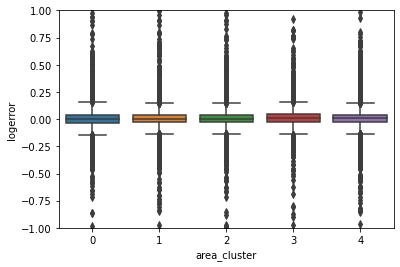

In [44]:
import seaborn as sns
sns.boxplot(y=y_train.logerror, x=X_train.area_cluster)
plt.ylim(-1, 1)
# sns.swarmplot(X_train.age_bin, y_train.logerror, hue=X_train.area_cluster)

I don't see any differences above that jump out at me.

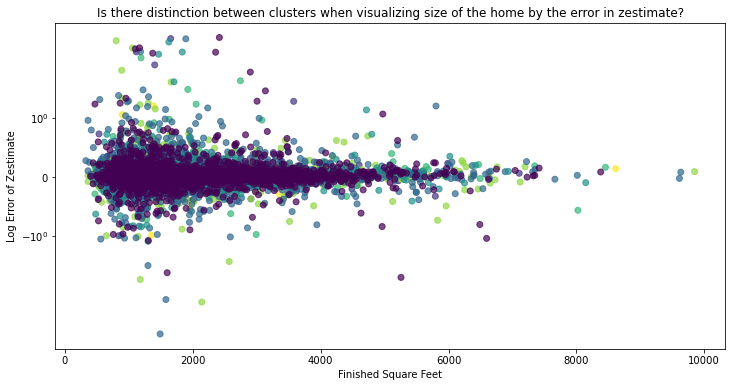

In [45]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=y_train.logerror, x=X_train.calculatedfinishedsquarefeet, c=X_train.size_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing size of the home by the error in zestimate?')

plt.show()

No, I don't see anything that stands out.

Let's look at the size clusters now.

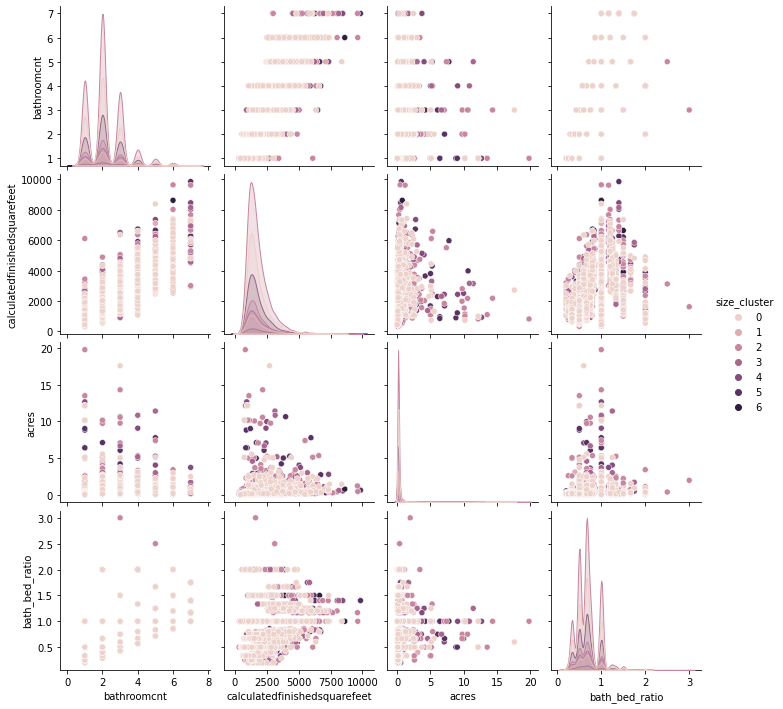

In [46]:
plt_df = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet', 
                    'acres', 'bath_bed_ratio', 'size_cluster']]

sns.pairplot(data=plt_df, hue='size_cluster')

<AxesSubplot:xlabel='bath_bed_ratio', ylabel='calculatedfinishedsquarefeet'>

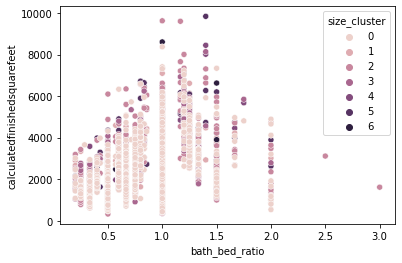

In [47]:
sns.scatterplot(x='bath_bed_ratio', y='calculatedfinishedsquarefeet', 
                data=X_train, hue='size_cluster')

Cluster Information:

1. Cluster 1: smaller lots
2. Cluster 6: Smaller lots

### Clusters used for Features

In [48]:
# update datatypes of binned values to be float
X_train = X_train.astype({'size_cluster': 'category', 'area_cluster': 'category'})


In [49]:
dummy_df = pd.get_dummies(X_train[['size_cluster','area_cluster']], dummy_na=False, drop_first=[True, True])

# append dummy df cols to the original df. 
X_train = pd.concat([X_train, dummy_df], axis=1)

In [50]:
X_train.head()

bathroomcnt  calculatedfinishedsquarefeet    latitude    longitude  \
38748          3.0                        1264.0  33976419.0 -118301352.0   
19330          2.0                        1300.0  34120981.0 -118346117.0   
46192          5.0                        2872.0  34141910.0 -118433056.0   
22550          2.0                        1344.0  34105184.0 -118377389.0   
45428          4.0                        3730.0  34125421.0 -118030828.0   

        age  age_bin   taxrate     acres  acres_bin  sqft_bin  ...  \
38748  94.0    0.666  1.217797  0.107415        0.1       0.3  ...   
19330  58.0    0.400  1.208293  0.281566        0.3       0.3  ...   
46192  90.0    0.600  1.242053  0.200964        0.2       0.6  ...   
22550  65.0    0.466  1.201040  0.080372        0.0       0.3  ...   
45428  28.0    0.200  1.146520  0.194812        0.2       0.7  ...   

       size_cluster_1  size_cluster_2  size_cluster_3  size_cluster_4  \
38748               0               0               0               1   
19330               0               0               0               1   
46192               0               0               0               1   
22550               0               0               0               1   
45428               0               0               0               1   

       size_cluster_5  size_cluster_6  area_cluster_1  area_cluster_2  \
38748               0               0               0               1   
19330               0               0               0               1   
46192               0               0               0               1   
22550               0               0               0               1   
45428               0               0               0               1   

      area_cluster_3  area_cluster_4  
38748              0               0  
19330              0               0  
46192              0               0  
22550              0               0  
45428              0               0  

[5 rows x 37 columns]

### Model Each Cluster Separately

Develop a model for each cluster, if we see that the patterns are different across the various clusters.

### Use Cluster Names as Target Variable for Supervised Learning

In [51]:
# plt.scatter(X_train.longitude, X_train.latitude, c = X_train.area_cluster)

In [52]:
# X_train.groupby(['area_cluster_id', 'size_cluster_id'])['structure_dollar_per_sqft'].describe()


In [53]:
import matplotlib
import sklearn

print('Versions')
print('Pandas:', pd.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-Learn:', sklearn.__version__)

Versions
Pandas: 1.1.3
Numpy: 1.19.2
Matplotlib: 3.3.2
Seaborn: 0.11.0
Scikit-Learn: 0.23.2
